## DEMENT in parallel

In [1]:
#..Load modules
import os
import sys
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from plotnine import *

In [2]:
from initialization_gradcatch import initialize_data
from grid_gradcatch import Grid
from output_gradcatch import Output
from utility import export

In [3]:
input_folder  = "input"   # input folder name
#...Set up the working directory
os.chdir(input_folder)

In [4]:
import joblib
from joblib import Parallel, delayed

In [5]:
def dement(outname, random_seed):
    #outname_t[i]  = "20220221" + str(int(i))    # output file name and seed of Pseudo-RNG + "20220211"
    input_folder  = "input"   # input folder name 
    output_folder = "output"  # output folder name
    #outname       = outname_t[i]
    #outname       = "20220131"   # output file name and seed of Pseudo-RNG
    #...Set up the working directory
    #  os.chdir(input_folder)
    #...seed the pseudorandom number generator
    np.random.seed(random_seed)

    #...a few system constants
    runtime    = pd.read_csv('runtime.txt',header=None,index_col=0,sep='\t')
    pulse      = int(runtime.loc['pulse',1])         # number of pulses
    cycle      = int(runtime.loc['end_time',1])      # number of time steps in each pulse
    interval   = int(runtime.loc['interval',1])      # interval of time step to record outputs
    mic_reinit = True    # indicate reinitialization of microbial community

    #...Initialize data by calling the Function: Initialize_Data()
    data_initialization = initialize_data(runtime)

    #...Prepare for output by creating an instance of the Output class
    Output_init = Output(runtime,data_initialization)

    #...Create an instance of the Grid class
    Ecosystem = Grid(runtime,data_initialization)

    #...Run the model
    for p in range(pulse):
        for i in range(p*cycle, (p+1)*cycle):
    
            # substrates degradation
            Ecosystem.degradation(p,i)

            # monomers uptake
            Ecosystem.uptake(p,i)

            # microbial metabolism
            Ecosystem.metabolism(i)

            # microbial death
            Ecosystem.mortality(i)

            # microbial reproduction and dispersal
            Ecosystem.reproduction(i)
    
            # output data using the "output" method in the Output class
            if i == 0:
                Output_init.output(Ecosystem,i)  # day 1
            elif i%interval==interval-1:
                Output_init.output(Ecosystem,i)  # interval
        
            # if only 1 pusle, skip all following lines within this loop
            #if pulse == 1:
            #    continue

            # output microbial mass of every iteration using the "microbes_df" method in the Output class
            Output_init.microbes_abundance(Ecosystem,i)

            # re-initialize microbial community in each new pulse
            if i == (p+1)*cycle-1:
                Ecosystem.repopulation(Output_init,i,mic_reinit)

    return Output_init

results = Parallel(n_jobs=2)(delayed(dement)("20240331" + str(int(i)),i) for i in range(2))

In [6]:
import pickle
output = open('C:/luciana_datos/UCI/Project_14 (Anna)/DEMENT_gradcatch/DEMENT/SP01/output/results_dement_1.pkl', 'wb')
pickle.dump(results, output)
output.close()

## Open the pickle output

In [7]:
#import 
import pickle
pkl_file = open('C:/luciana_datos/UCI/Project_14 (Anna)/DEMENT_gradcatch/DEMENT/SP01/output/results_dement_1.pkl', 'rb')
test     = pickle.load(pkl_file)
pkl_file.close()

## Test Plots

In [8]:
tt        = np.linspace(0,1,2) # Number of repetitions = 4
time      = np.linspace(0,365*2,365*2+1)

### Respiration

In [9]:
respi_base     = []

for i in tt:
        respi_base.append(test[int(i)].RespSeries)

Respi_mean = (np.array(respi_base).mean(axis=0))
respiration_5  = np.percentile(respi_base,5,axis=0)
respiration_95 = np.percentile(respi_base,95,axis=0)

C:\Users\lucia\AppData\Local\Temp\ipykernel_16468\187784392.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


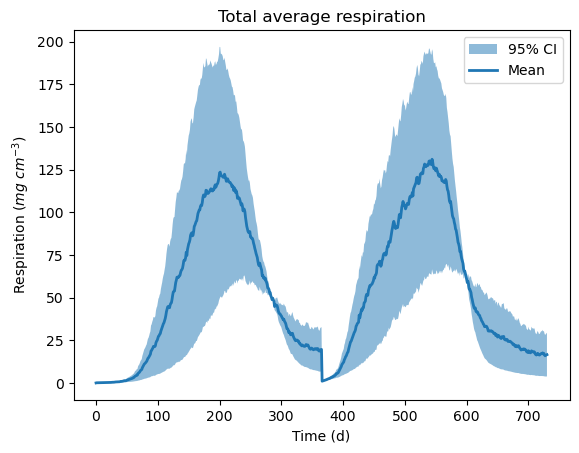

In [10]:
fig, ax = plt.subplots()

ax.fill_between(time,respiration_5,respiration_95, alpha=.5, linewidth=0,label="95% CI")
ax.plot(time,Respi_mean, linewidth=2,label="Mean")

plt.xlabel('Time (d)') 
plt.ylabel('Respiration ($mg$ $cm^{-3}$)') 
plt.title('Total average respiration') 
ax.legend()
fig.show()

In [11]:
Subst_tot = []

for i in tt:
    Subst_tot.append(test[int(i)].SubstratesSeries)

Sub_sum     = np.mean((np.array(Subst_tot).sum(axis=1)),axis=0)
Sub_05      = np.percentile((np.array(Subst_tot).sum(axis=1)),5,axis=0)
Sub_95      = np.percentile((np.array(Subst_tot).sum(axis=1)),95,axis=0)

C:\Users\lucia\AppData\Local\Temp\ipykernel_16468\3386710776.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


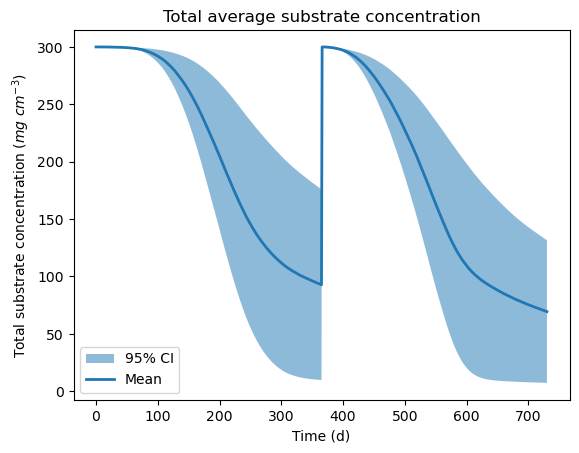

In [12]:
fig, ax = plt.subplots()

ax.fill_between(time,Sub_05/100,Sub_95/100, alpha=.5, linewidth=0,label="95% CI")
ax.plot(time,Sub_sum/100, linewidth=2,label="Mean")

plt.xlabel('Time (d)') 
plt.ylabel('Total substrate concentration ($mg$ $cm^{-3}$)') 
plt.title('Total average substrate concentration') 
ax.legend(loc="lower left")
fig.show()

In [22]:
(Sub_05[0]/100-Sub_05[365*2]/100)*100/(Sub_05[0]/100)

97.58291304970527

In [21]:
Sub_95[365*2]/100

131.4806398313504

In [16]:
parameters      = pd.read_csv('parameters_cellulose_1.csv',header=None, index_col=0).astype('float32')
parameters.loc["Init_NH4",1]

0.09

In [8]:
test[int(0)].MonomersSeries.T

,NH4,PO4,DeadMic,DeadEnz,Mon3,Mon4,Mon5,Mon6,Mon7,Mon8,Mon9,Mon10,Mon11,Mon12
0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.000000,0.000000e+00,0.008421,0.024128,0.004125,0.004398,0.001062,0.003605,0.008622,0.002554,0.002647,0.001646
3,0.0,0.0,0.000000,1.294914e-07,0.023967,0.068927,0.011857,0.012623,0.003015,0.010262,0.024794,0.007338,0.007588,0.004740
4,0.0,0.0,0.000000,6.746027e-07,0.046086,0.132824,0.022919,0.024342,0.005745,0.019590,0.047908,0.014150,0.014620,0.009152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.0,0.0,0.000443,9.593347e-04,0.565157,2.055384,0.767025,0.423851,0.015547,0.052983,1.003076,0.373351,0.213983,0.112753
97,0.0,0.0,0.000403,9.165822e-04,0.552032,1.993897,0.759533,0.410684,0.015116,0.052508,0.981109,0.364289,0.212640,0.112716
98,0.0,0.0,0.000368,8.191672e-04,0.554324,2.035872,0.748535,0.404285,0.012934,0.046418,0.974647,0.360192,0.210477,0.111008
99,0.0,0.0,0.000342,7.639877e-04,0.521486,2.037844,0.740932,0.404735,0.011076,0.042006,0.999124,0.356266,0.203468,0.110098


In [14]:
test[int(0)].PO4Series

0       1.900000
1       1.772406
2       1.667830
3       1.583137
4       1.513953
          ...   
1091    0.502543
1092    0.483529
1093    0.473973
1094    0.487006
1095    0.521431
Length: 1096, dtype: float64

In [ ]:
test[int(1)].MonomersSeries.T

In [ ]:
test[int(0)].MonomersSeries.T["Mon3"]

In [ ]:
test[int(0)].MonomersSeries.T["Mon3"]